# Домашнее задание № 3. Модели ARIMA и GARCH, прогнозирование значений на их основе.
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [111]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [112]:
def tsplot(y, lags=None, figsize=(10, 7), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(7):
        for d in range(7):
            for j in range(7):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

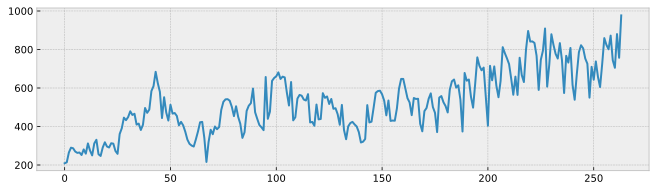

In [113]:
series = pd.read_csv('Series/monthly-us-auto-registration-tho.csv', sep=';')
series.columns = ['Month', 'Count']
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 3))
    plt.plot(series['Count'])

# Нестационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


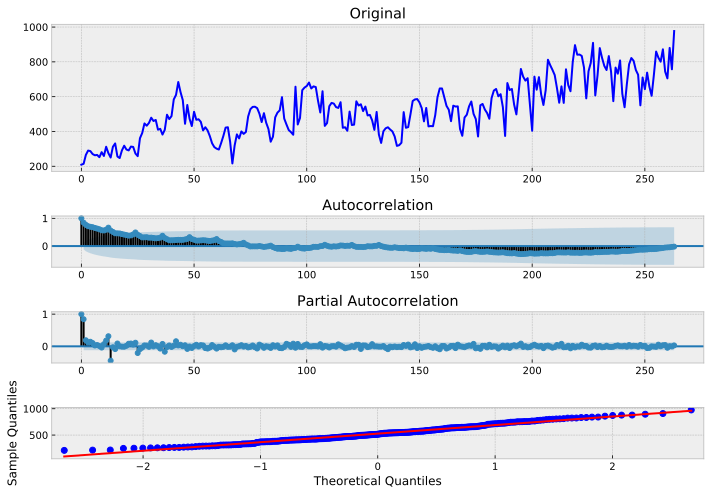

In [114]:
ser = series["Count"].values.astype('float64')

tsplot(ser)

In [115]:
aic, order, mdl = _get_best_model(ser)

aic: 3001.68500 | order: (6, 2, 5)


Results of Dickey-Fuller Test:
Test Statistic                  -4.181639
p-value                          0.000708
#Lags Used                      12.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


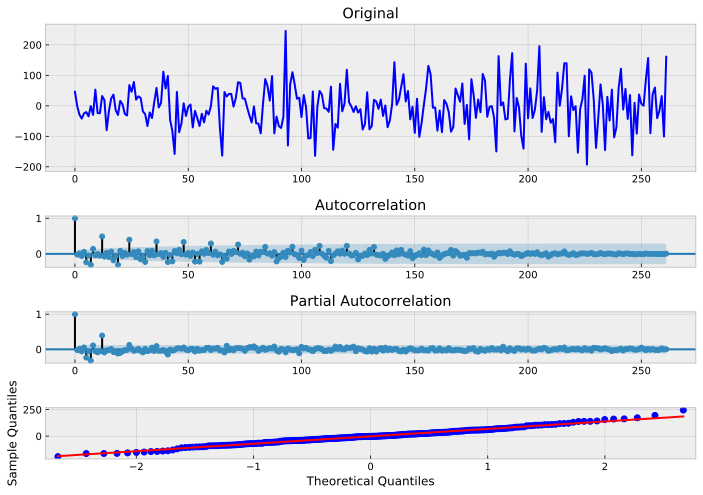

In [116]:
tsplot(mdl.resid)

In [117]:
aic, order, mdl = _get_best_model(ser[:-15])

aic: 2828.06132 | order: (5, 1, 6)


## Посмотрим на предсказание модели ARIMA

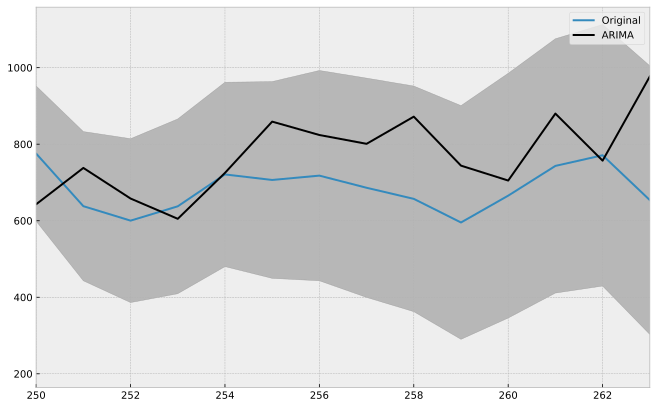

In [118]:
with plt.style.context('bmh'):
    plt.figure(figsize=(11,7))
    ax = plt.axes()
    mdl.plot_predict(1, len(ser), plot_insample=False, ax=ax)
    plt.plot(ser, color='black', label='Original')
    plt.xlim(250, 263)
    plt.legend(['Original', 'ARIMA'])  

## Видно, что предсказание лучше, чем было на моделях простого скользящего среднего. Модель в целом понимает некоторые тенденции изменения реальных данных.

## Построим GARCH модель.

In [54]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 6
o_ = 2
q_ = 5

# Using student T distribution usually provides better fit
am = arch_model(ser, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.044
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.044
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1654.71
Distribution:      Standardized Student's t   AIC:                           3341.42
Method:                  Maximum Likelihood   BIC:                           3398.63
                                              No. Observations:                  264
Date:                      Mon, May 27 2019   Df Residuals:                      248
Time:                              21:40:26   Df Model:                           16
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


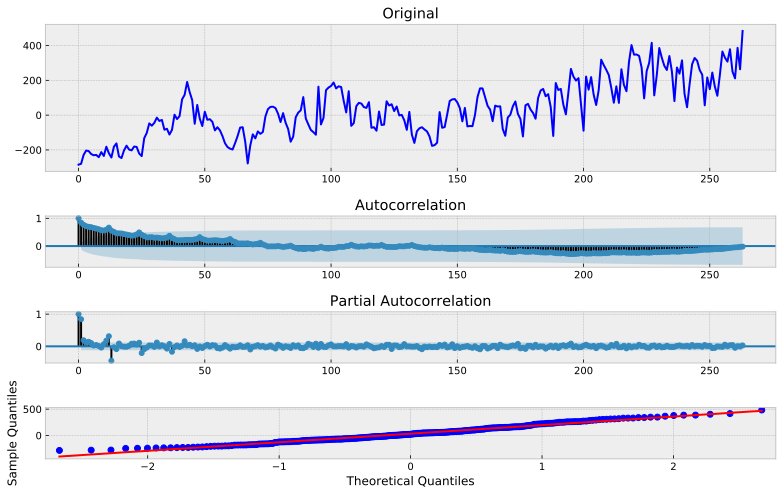

In [55]:
tsplot(res.resid)

# Стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


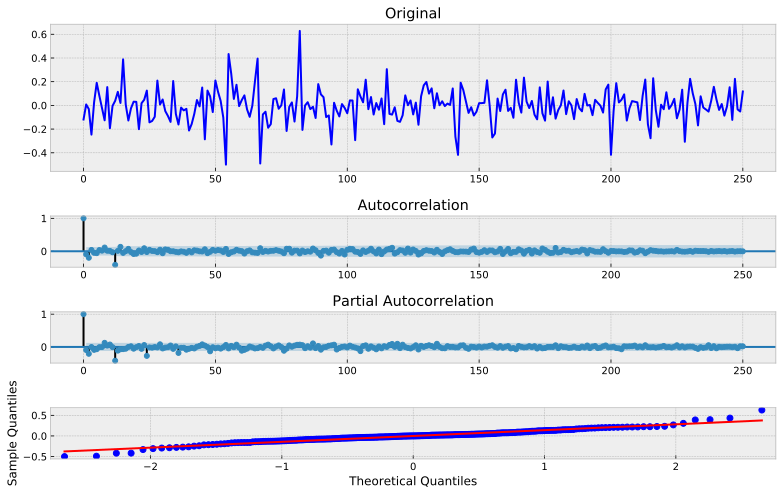

In [4]:
seriesv = series["Count"].values.astype('float64')
seriesv = boxcox(seriesv, 0)
seriesv = seriesv[1:] - seriesv[:-1]
seriesv = seriesv[12:] - seriesv[:-12]
tsplot(seriesv)

In [5]:
aic, order, mdl = _get_best_model(seriesv)

aic: -301.21030 | order: (4, 0, 6)


Results of Dickey-Fuller Test:
Test Statistic                  -5.390995
p-value                          0.000004
#Lags Used                      13.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


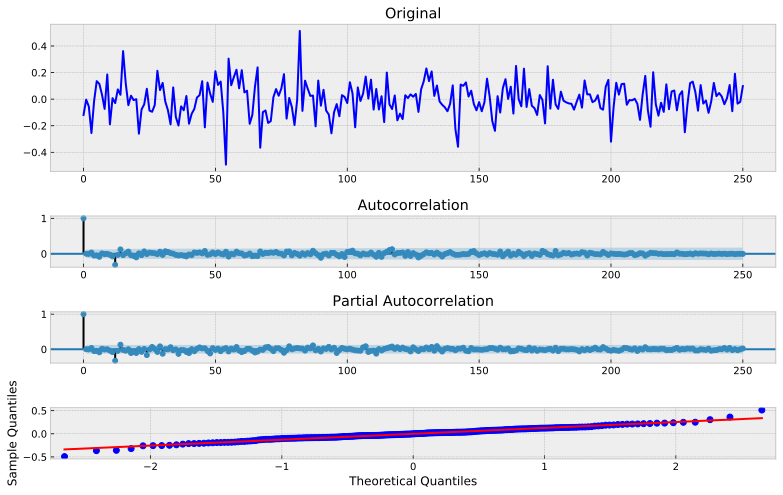

In [6]:
tsplot(mdl.resid)

In [23]:
aic, order, mdl = _get_best_model(seriesv[:-10])

aic: -283.32224 | order: (6, 0, 6)


## Посмотрим на предсказания модели ARIMA

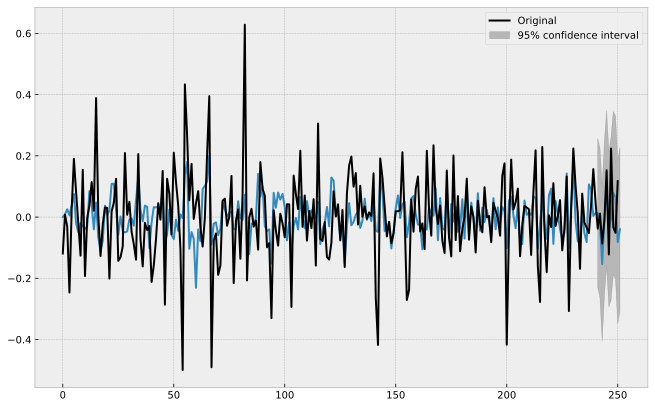

In [24]:
with plt.style.context('bmh'):
    plt.figure(figsize=(11,7))
    ax = plt.axes()
    mdl.plot_predict(0, len(seriesv), plot_insample=False, ax=ax)
    plt.plot(seriesv, color='black', label='Original')
    plt.legend()
    plt.show()

## И ближе

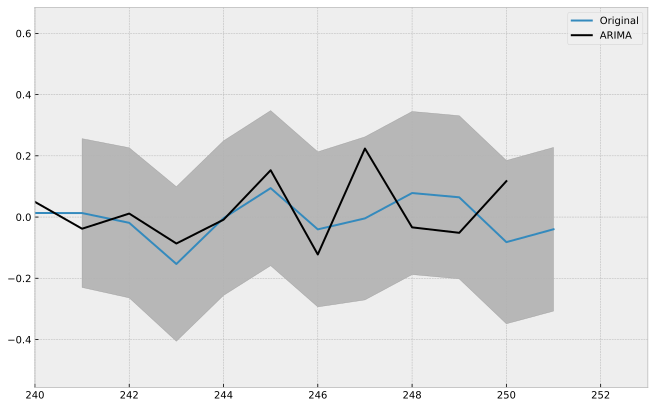

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize=(11,7))
    ax = plt.axes()
    mdl.plot_predict(0, len(seriesv), plot_insample=False, ax=ax)
    plt.plot(seriesv, color='black', label='Original')
    plt.xlim(240, 253)
    plt.legend(['Original', 'ARIMA'])    

## Построим GARCH модель

In [8]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(seriesv, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                152.388
Distribution:      Standardized Student's t   AIC:                          -278.776
Method:                  Maximum Likelihood   BIC:                          -232.945
                                              No. Observations:                  251
Date:                      Mon, May 27 2019   Df Residuals:                      238
Time:                              20:59:57   Df Model:                           13
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


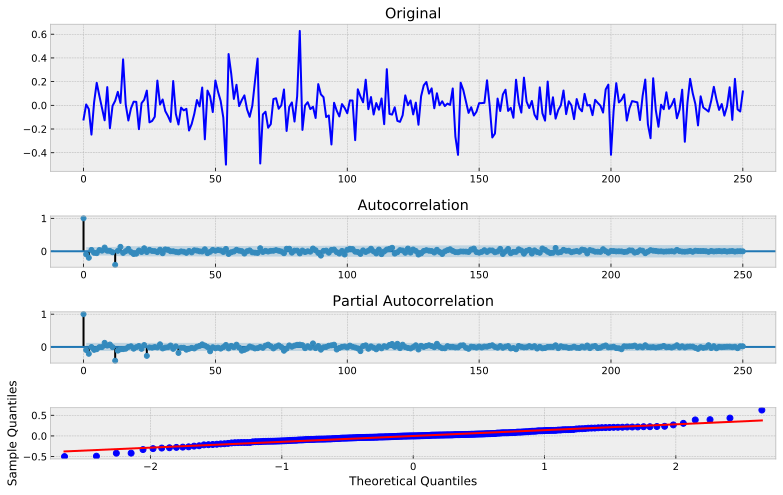

In [9]:
tsplot(res.resid)

# Классический ML. Будем использовать XGBRegressor.

In [67]:
def prepareData(data, lag_start=5, lag_end=20, test_size=6):
    
    data = data.copy()
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = -test_size
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Count'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(['Count'], axis=1)
    y_train = data.iloc[:test_index]['Count']
    X_test = data.iloc[test_index:].drop(['Count'], axis=1)
    y_test = data.iloc[test_index:]['Count']
    
    return X_train, X_test, y_train, y_test

In [86]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=15)

In [89]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

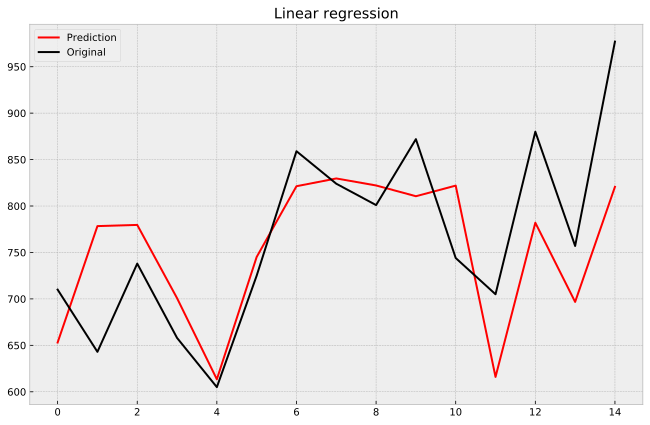

In [88]:
lr = XGBRegressor(4)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(pred, "red", label="prediction")
    plt.plot(y_test.values, 'black', label="actual")
    plt.title("Linear regression")
    plt.legend(['Prediction', 'Original'])
    plt.grid(True)

# В целом видно, что предсказание довольно неплохо описывает реальные данные. 

In [90]:
mean_squared_error(pred, y_test.values)

5531.0336838888625